In [1]:
! pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.0 MB/s eta 0:00:00


## Import Library

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV

from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
                             roc_curve, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Loading Dataset

In [3]:
twitter_data = pd.read_csv('60k_tweet_datasets.csv')


In [4]:
twitter_data.shape

(60000, 7)

In [5]:
twitter_data.head()

,Unnamed: 0,target,id,date,flag,user,text
0,0,0,2256346705,Sat Jun 20 12:38:13 PDT 2009,NO_QUERY,erupert66,@ShawnKing at least you are home. we were at ...
1,1,1,1970346195,Sat May 30 03:29:27 PDT 2009,NO_QUERY,PaulHarriott,@mcherrywv And a very lovely morning to you
2,2,1,1989702085,Mon Jun 01 02:30:13 PDT 2009,NO_QUERY,Maarylin,http://twitpic.com/6e6f2 - Maaarie !! You're s...
3,3,0,2202413219,Tue Jun 16 21:45:14 PDT 2009,NO_QUERY,Lisa_Henry,"@Jessiahbella But, heard on the boards that th..."
4,4,0,2186527534,Mon Jun 15 18:58:10 PDT 2009,NO_QUERY,nutzoyc,Finally home.. Had fun in vegas but was starti...


In [6]:
twitter_data.isnull().sum()

,0
Unnamed: 0,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [7]:
# kiểm tra sự phân bố của các nhãn
# nếu các nhãn phân bố không đồng đều, phải thực hiện lấy mẫu ngẫu nhiên
twitter_data['target'].value_counts()

,count
target,
0,30000
1,30000


## Preprocessing

Gồm các công việc:
- Chuyển tất cả chữ cái thành chữ thường
- Mở rộng từ viết tắt
- Loại bỏ các url và username có trong tweet
- Loại bỏ dấu câu
- loại bỏ stopword
- Lemmatization

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)


In [9]:
text = "I can't believe this product is amazing!!! 😍 Check it out: https://example.com"
processed_text = preprocess_text(text)
print(processed_text)

believe product amazing check


In [10]:
twitter_data['clean_data'] = twitter_data['text'].apply(preprocess_text)

In [11]:
twitter_data.head()

,Unnamed: 0,target,id,date,flag,user,text,clean_data
0,0,0,2256346705,Sat Jun 20 12:38:13 PDT 2009,NO_QUERY,erupert66,@ShawnKing at least you are home. we were at ...,least home beach week single good day beach we...
1,1,1,1970346195,Sat May 30 03:29:27 PDT 2009,NO_QUERY,PaulHarriott,@mcherrywv And a very lovely morning to you,lovely morning
2,2,1,1989702085,Mon Jun 01 02:30:13 PDT 2009,NO_QUERY,Maarylin,http://twitpic.com/6e6f2 - Maaarie !! You're s...,maaarie cool like time past
3,3,0,2202413219,Tue Jun 16 21:45:14 PDT 2009,NO_QUERY,Lisa_Henry,"@Jessiahbella But, heard on the boards that th...",heard board coded region work newer player min...
4,4,0,2186527534,Mon Jun 15 18:58:10 PDT 2009,NO_QUERY,nutzoyc,Finally home.. Had fun in vegas but was starti...,finally home fun vega starting get home sick t...


In [12]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  60000 non-null  int64 
 1   target      60000 non-null  int64 
 2   id          60000 non-null  int64 
 3   date        60000 non-null  object
 4   flag        60000 non-null  object
 5   user        60000 non-null  object
 6   text        60000 non-null  object
 7   clean_data  60000 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.7+ MB


In [13]:
print(twitter_data['clean_data'])

0        least home beach week single good day beach we...
1                                           lovely morning
2                              maaarie cool like time past
3        heard board coded region work newer player min...
4        finally home fun vega starting get home sick t...
                               ...                        
59995    consider david caption could inside scoop concert
59996    p today start new adventure good luck hope gre...
59997                        bah log meteor need free text
59998                     sun nashville today stuck inside
59999                  checking twitter first time woo hoo
Name: clean_data, Length: 60000, dtype: object


In [14]:
print(twitter_data['target'])

0        0
1        1
2        1
3        0
4        0
        ..
59995    1
59996    1
59997    0
59998    0
59999    1
Name: target, Length: 60000, dtype: int64


In [15]:
X = twitter_data['clean_data'].values
Y = twitter_data['target'].values

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)

In [17]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [18]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 276296 stored elements and shape (48000, 5000)>
  Coords	Values
  (0, 4796)	0.32411603785043647
  (0, 1784)	0.2740077982656995
  (0, 2881)	0.43308082998560277
  (0, 3161)	0.462468201636417
  (0, 4288)	0.4291123545181854
  (0, 1880)	0.33779077099173416
  (0, 4776)	0.34668813060811154
  (1, 1599)	0.34790208226797337
  (1, 1679)	0.5562648688513536
  (1, 4426)	0.24490212425318275
  (1, 3829)	0.521761750889493
  (1, 2583)	0.30721429473578504
  (1, 1833)	0.23076256859384703
  (1, 1961)	0.2994815114933945
  (2, 2226)	0.6405017147954792
  (2, 3134)	0.4724634749809593
  (2, 1565)	0.3394955111131013
  (2, 2526)	0.28214644653792764
  (2, 4004)	0.4143331977925997
  (3, 1784)	0.20159258737114064
  (3, 422)	0.2692810588496122
  (3, 3171)	0.46005085192887346
  (3, 2303)	0.4633475120672528
  (3, 2581)	0.37848248394588546
  (3, 1665)	0.3759594771470057
  :	:
  (47995, 297)	0.24247115705478253
  (47995, 1972)	0.23586150240567316
  (47995, 430

In [19]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 67901 stored elements and shape (12000, 5000)>
  Coords	Values
  (0, 1380)	0.364066876589473
  (0, 1820)	0.21854144260803304
  (0, 1825)	0.2107265723683512
  (0, 3532)	0.24230072930846797
  (0, 3798)	0.43380850573407875
  (0, 4367)	0.2762633614660695
  (0, 4748)	0.22836298526837207
  (0, 4833)	0.45764428193564405
  (0, 4927)	0.4364406135350092
  (1, 459)	0.4754694241146753
  (1, 521)	0.35654909095754356
  (1, 1565)	0.2897298555161364
  (1, 2571)	0.2608690389224513
  (1, 2976)	0.5610351233362272
  (1, 4191)	0.3432040022106123
  (1, 4426)	0.24951178543989877
  (2, 1474)	0.4959605205773448
  (2, 1784)	0.3193050740335021
  (2, 2603)	0.3368311499827033
  (2, 3002)	0.7339020425959031
  (3, 313)	0.2768677312696683
  (3, 342)	0.5035701565237205
  (3, 450)	0.3765804429828998
  (3, 2855)	0.43853438775109244
  (3, 4426)	0.2635296543263375
  :	:
  (11995, 4963)	0.5878587971689453
  (11996, 1105)	0.3060953746810691
  (11996, 1797)	0.7895

## Training Model

### GaussianNB

Best var_smoothing: {'var_smoothing': 1e-05}
Best CV Accuracy: 0.6560625

Test Accuracy: 0.6684166666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.68      6000
           1       0.68      0.64      0.66      6000

    accuracy                           0.67     12000
   macro avg       0.67      0.67      0.67     12000
weighted avg       0.67      0.67      0.67     12000

AUC Score: 0.6906864583333334


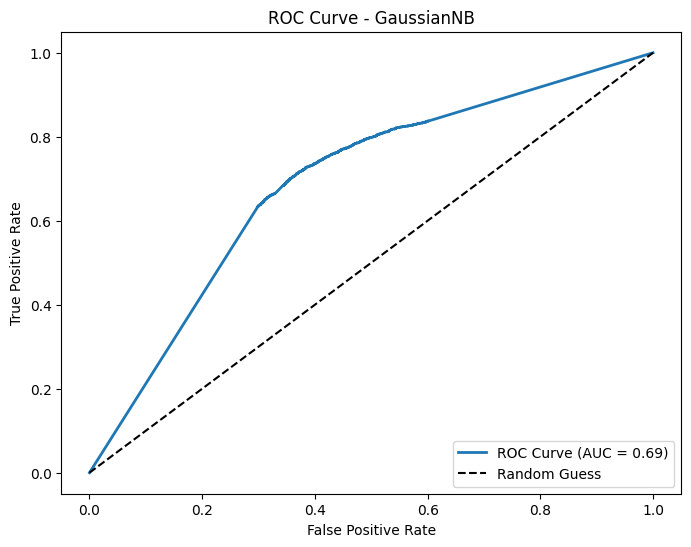

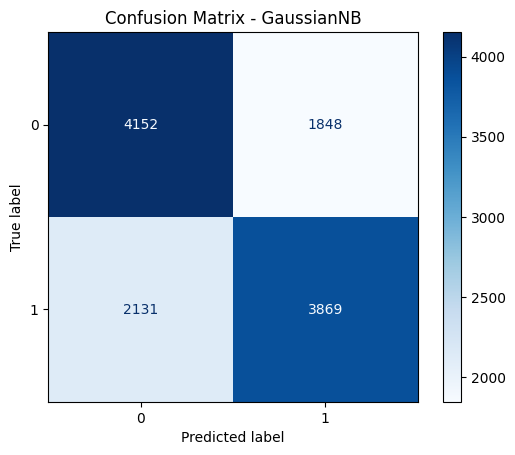

In [36]:
gnb = GaussianNB()
X_train_GB = X_train.toarray()

param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
grid_search = GridSearchCV(gnb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_GB, y_train)

print("Best var_smoothing:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

best_gnb = grid_search.best_estimator_
X_test_GB = X_test.toarray()
y_pred = best_gnb.predict(X_test_GB)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

if hasattr(best_gnb, "predict_proba"):
    y_proba = best_gnb.predict_proba(X_test_GB)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - GaussianNB")
    plt.legend(loc="lower right")
    plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GaussianNB")
plt.show()

### Bernoulli Naive Bayes

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'alpha': 5.0}
Best Cross-Validation Accuracy: 0.7455833333333333

Test Accuracy: 0.7433333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.74      6000
           1       0.73      0.76      0.75      6000

    accuracy                           0.74     12000
   macro avg       0.74      0.74      0.74     12000
weighted avg       0.74      0.74      0.74     12000

AUC Score: 0.8198395555555555


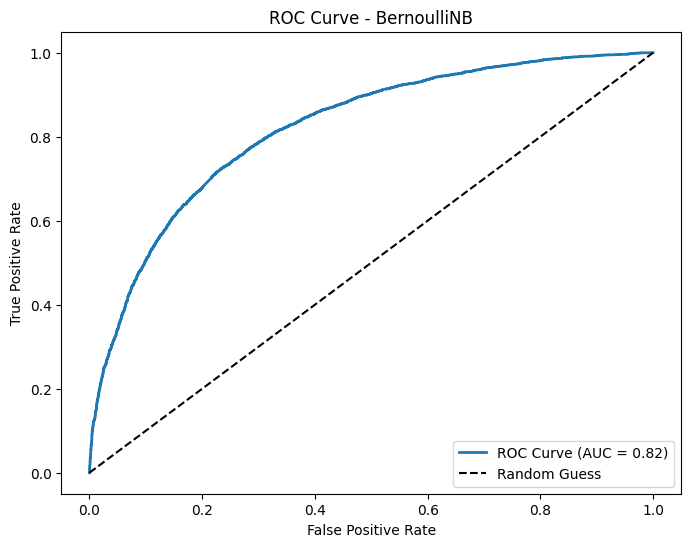

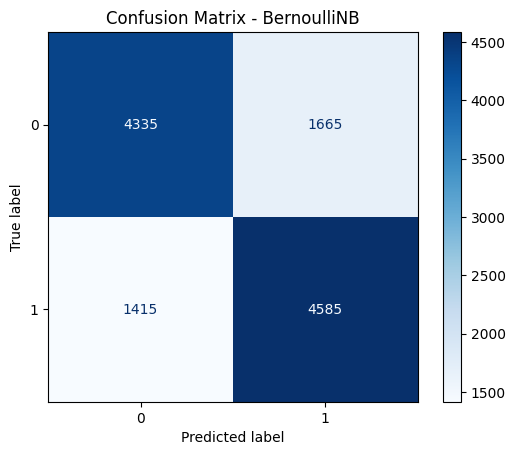

In [39]:
bnb = BernoulliNB()
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

grid_search = GridSearchCV(bnb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_bnb = grid_search.best_estimator_
y_pred = best_bnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_proba = best_bnb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - BernoulliNB")
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BernoulliNB")
plt.show()

### KNN

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_neighbors': 3}
Best Cross-Validation Accuracy: 0.5941041666666668

Test Accuracy: 0.60825

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.77      0.66      6000
           1       0.66      0.45      0.54      6000

    accuracy                           0.61     12000
   macro avg       0.62      0.61      0.60     12000
weighted avg       0.62      0.61      0.60     12000

AUC Score: 0.6549775694444445


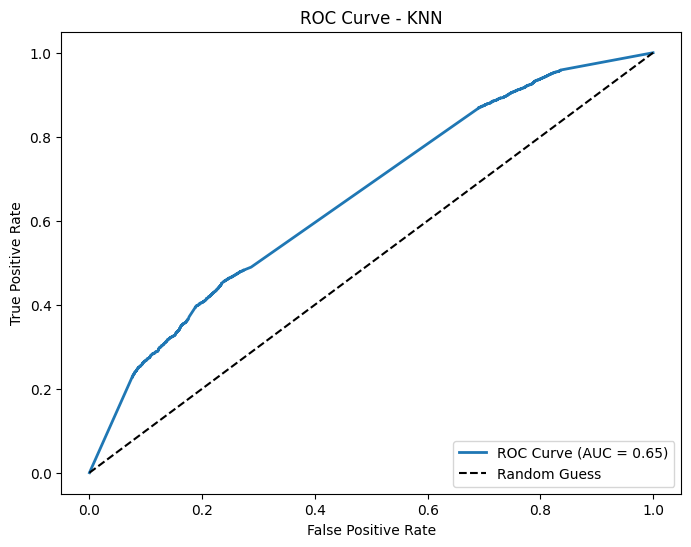

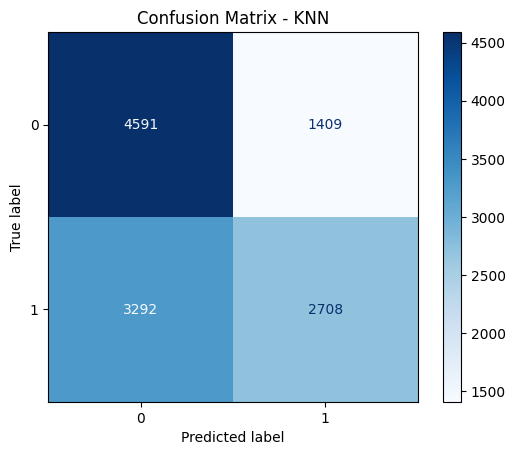

In [41]:
knn = KNeighborsClassifier(weights='distance',metric='euclidean')

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

if hasattr(best_knn, "predict_proba"):
    y_proba = best_knn.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - KNN")
    plt.legend(loc="lower right")
    plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
plt.show()

### Logistic Regression

Best Parameters: {'C': 1, 'penalty': 'l2'}
Best CV Accuracy: 0.7480208333333334
Test Accuracy: 0.7475

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74      6000
           1       0.74      0.77      0.75      6000

    accuracy                           0.75     12000
   macro avg       0.75      0.75      0.75     12000
weighted avg       0.75      0.75      0.75     12000

AUC Score: 0.8264451111111111


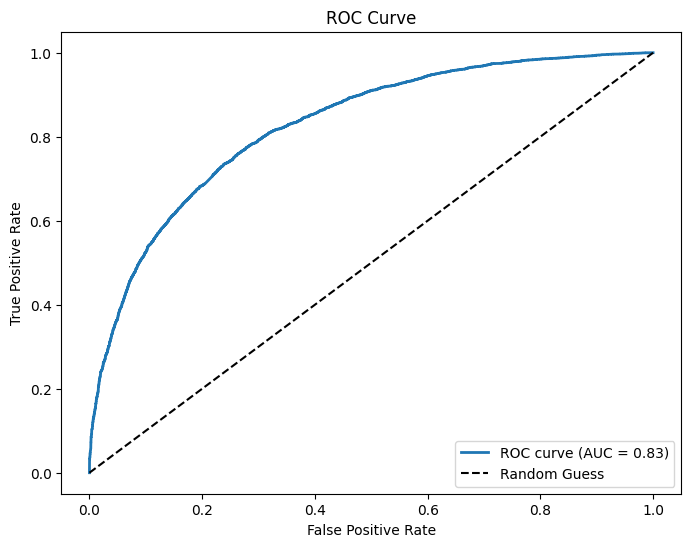

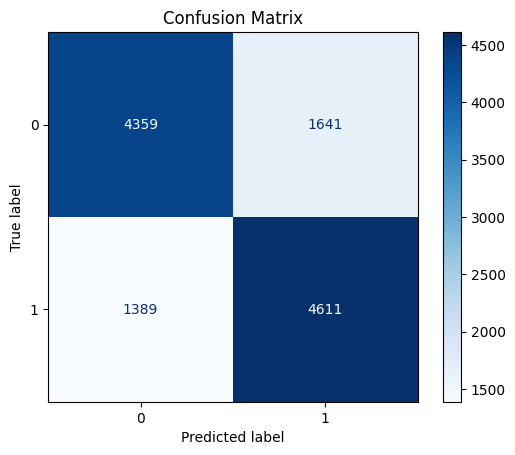

In [20]:

lr = LogisticRegression(solver='liblinear', random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_proba = grid_search.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### SVM

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Best Cross-Validation Accuracy: 0.7481875

Test Accuracy: 0.7463333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74      6000
           1       0.73      0.77      0.75      6000

    accuracy                           0.75     12000
   macro avg       0.75      0.75      0.75     12000
weighted avg       0.75      0.75      0.75     12000



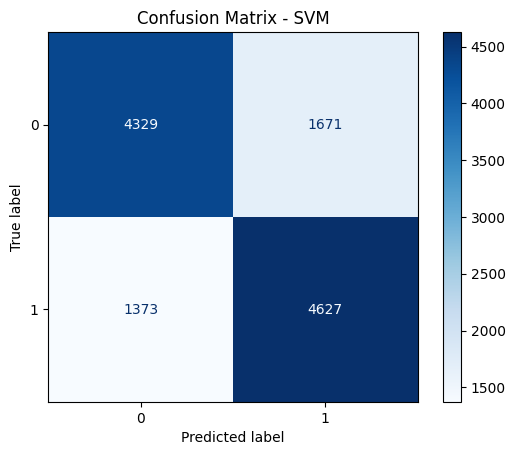

In [25]:
svm = LinearSVC(random_state=42)

param_grid = {'penalty':['l1', 'l2'],
              'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.show()

### Decision tree

Best Parameters: {'max_depth': 100, 'min_samples_split': 500}
Best Cross-Validation Accuracy: 0.674125

Test Accuracy: 0.6675833333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60      6000
           1       0.63      0.83      0.71      6000

    accuracy                           0.67     12000
   macro avg       0.69      0.67      0.66     12000
weighted avg       0.69      0.67      0.66     12000

AUC Score: 0.727060888888889


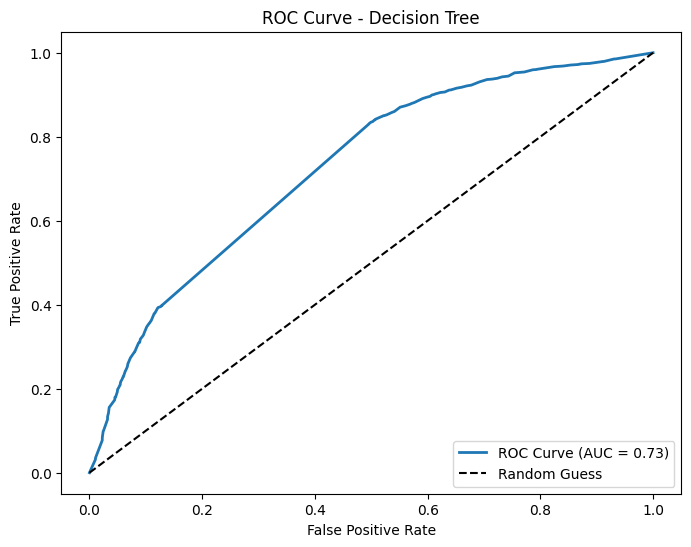

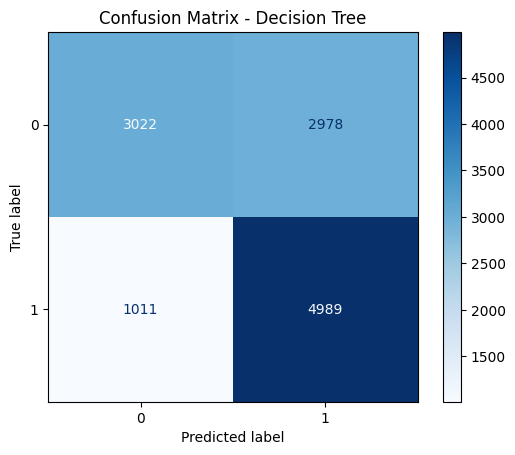

In [22]:
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [1, 10, 20, 50,100],
    'min_samples_split': [5, 10, 100, 500]
}

grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

if hasattr(grid_search.best_estimator_, "predict_proba"):
    y_proba = grid_search.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Decision Tree")
    plt.legend(loc="lower right")
    plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

### Random Forest

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'max_depth': 50, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.7145

Test Accuracy: 0.7066666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.60      0.67      6000
           1       0.67      0.81      0.73      6000

    accuracy                           0.71     12000
   macro avg       0.72      0.71      0.70     12000
weighted avg       0.72      0.71      0.70     12000

AUC Score: 0.7945951944444445


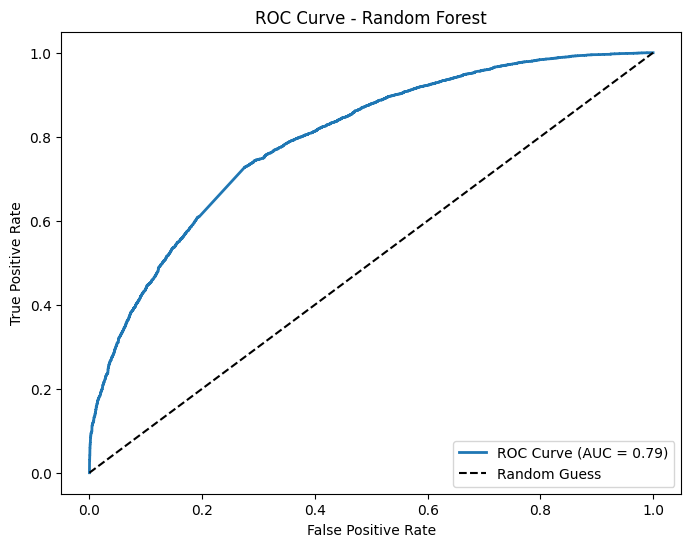

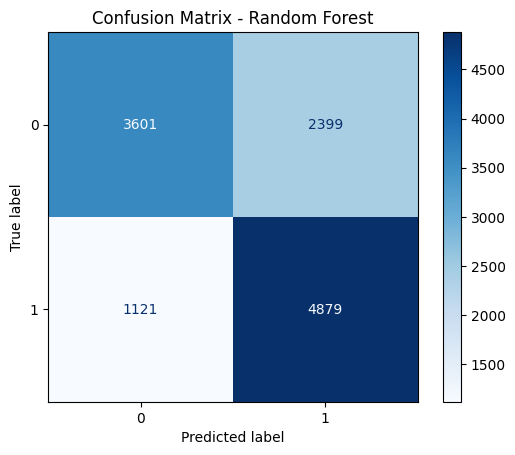

In [27]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced')

param_grid = {
    'n_estimators': [5, 50, 100,150,200],
    'max_depth': [ 5, 10, 30,50,120]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


if hasattr(best_rf, "predict_proba"):
    y_proba = best_rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest")
    plt.legend(loc="lower right")
    plt.show()

# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()


### XGBoost

Fitting 3 folds for each of 35 candidates, totalling 105 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:40:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'max_depth': 30, 'n_estimators': 100}
Best CV Accuracy: 0.7242083333333333

Test Accuracy: 0.7265833333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.68      0.71      6000
           1       0.71      0.77      0.74      6000

    accuracy                           0.73     12000
   macro avg       0.73      0.73      0.73     12000
weighted avg       0.73      0.73      0.73     12000

AUC Score: 0.8034675694444444


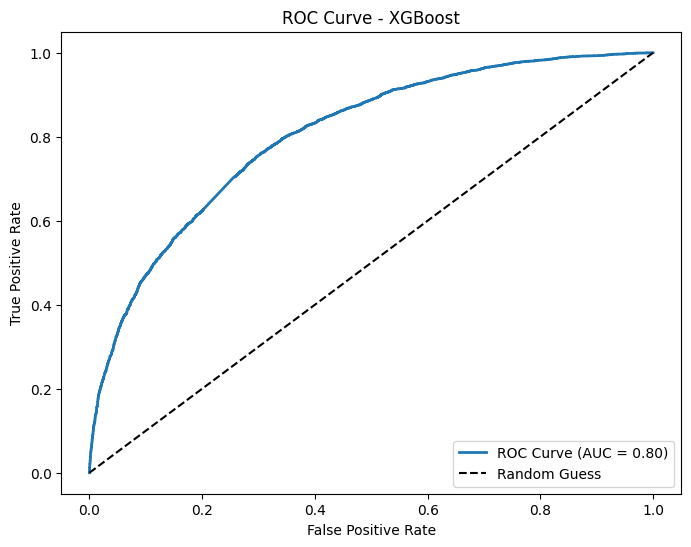

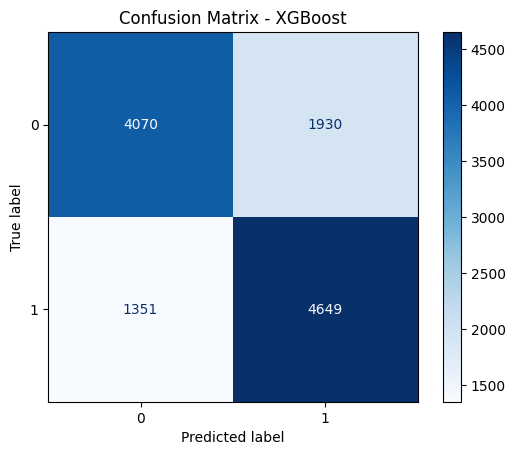

In [42]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)

# 5. Set up hyperparameter grid for tuning
param_grid = {
    'n_estimators': [5, 10, 50, 100, 120],
    'max_depth': [1, 5, 7, 10, 15, 25, 30]
}

# 6. Optimize the model using GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# 7. Evaluate the optimized model on the test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate AUC (if needed) using predicted probabilities for the positive class
if hasattr(best_xgb, "predict_proba"):
    y_proba = best_xgb.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - XGBoost")
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

## Conclusion

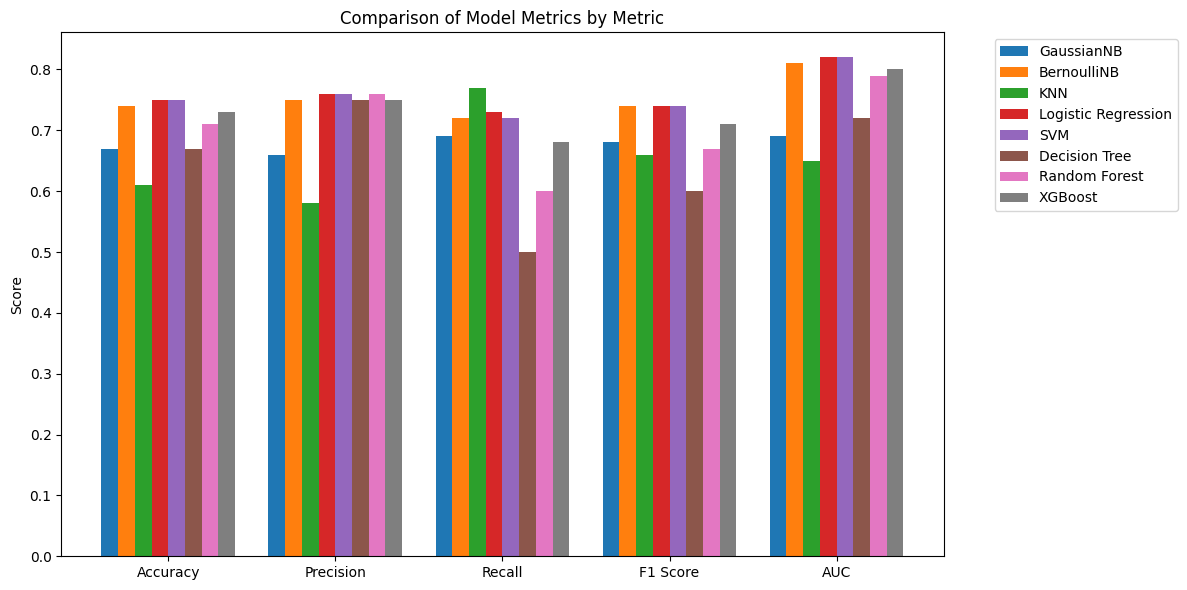

In [71]:
import matplotlib.pyplot as plt
import numpy as np
metrics = {
    'GaussianNB':            {'Accuracy': 0.67, 'Precision': 0.66, 'Recall': 0.69, 'F1 Score': 0.68, 'AUC': 0.69},
    'BernoulliNB':           {'Accuracy': 0.74, 'Precision': 0.75, 'Recall': 0.72, 'F1 Score': 0.74, 'AUC': 0.81},
    'KNN':                   {'Accuracy': 0.61, 'Precision': 0.58, 'Recall': 0.77, 'F1 Score': 0.66, 'AUC': 0.65},
    'Logistic Regression': {'Accuracy': 0.75, 'Precision': 0.76, 'Recall': 0.73, 'F1 Score': 0.74, 'AUC': 0.82},
    'SVM':                   {'Accuracy': 0.75, 'Precision': 0.76, 'Recall': 0.72, 'F1 Score': 0.74, 'AUC': 0.82},
    'Decision Tree':         {'Accuracy': 0.67, 'Precision': 0.75, 'Recall': 0.5, 'F1 Score': 0.6, 'AUC': 0.72},
    'Random Forest':         {'Accuracy': 0.71, 'Precision': 0.76, 'Recall': 0.6, 'F1 Score': 0.67, 'AUC': 0.79},
    'XGBoost':               {'Accuracy': 0.73, 'Precision': 0.75, 'Recall': 0.68, 'F1 Score': 0.71, 'AUC': 0.8}
}

model_names = list(metrics.keys())
metric_names = list(next(iter(metrics.values())).keys())


x = np.arange(len(metric_names))
n_models = len(model_names)
width = 0.8 / n_models

fig, ax = plt.subplots(figsize=(12, 6))


for i, model in enumerate(model_names):
    offset = -0.4 + (i + 0.5) * width
    values = [metrics[model][m] for m in metric_names]
    ax.bar(x + offset, values, width, label=model)

ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Metrics by Metric')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Save model


In [67]:
import joblib
joblib.dump(best_svm, 'svm_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')



['vectorizer.pkl']

## Load and use model

In [68]:
model = joblib.load('svm_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

In [70]:
def predict_sentiment(text, model, vectorizer):
    """
    Predicts sentiment from raw text using the given model and vectorizer.

    Parameters:
      text (str or list of str): The raw input text.
      model: The trained model (e.g., a scikit-learn estimator).
      vectorizer: The fitted vectorizer used to transform raw text (e.g., TfidfVectorizer).

    Returns:
      prediction: The predicted sentiment label(s).
    """
    if isinstance(text, str):
        text = [text]

    text_features = vectorizer.transform(text)
    prediction = model.predict(text_features)

    return prediction

# Example
sample_text = "Insanity of today weirdo massive selling. $aapl bid up 45 cents after hours after non stop selling in trading hours"
predicted_label = predict_sentiment(sample_text, model, vectorizer)
print("Predicted Sentiment:", predicted_label)


Predicted Sentiment: [0]
